This version of the example uses lmfit (https://lmfit.github.io/lmfit-py/) with an explicitly defined objective function

In [5]:
import numpy as np
from lmfit import minimize, Parameters
import matplotlib.pyplot as plt

In [6]:
# Generate example data according to an exponential PDF
np.random.seed(42)
lambda_=3.14159   # lambda is a keyword, so use lambda_ instead!
x_true = np.random.exponential(scale=lambda_, size=1000)

# Create histogram of the data
range=(0.0,4.0)
counts, bin_edges = np.histogram(x_true, bins=50, range=range, density=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
errs = np.sqrt(counts)

<ErrorbarContainer object of 3 artists>

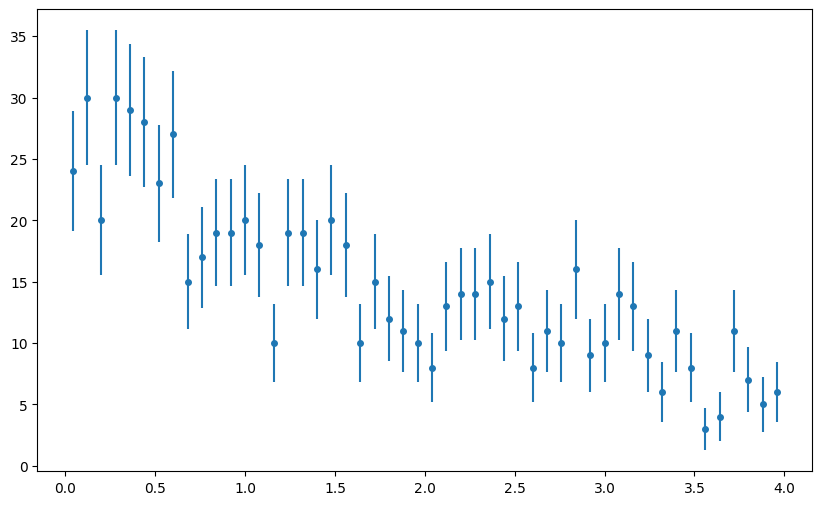

In [7]:
plt.figure(figsize=(10, 6))
plt.errorbar(bin_centers, counts, yerr=errs, fmt='o', label='Data', markersize=4)

In [8]:
# Define the model function
def expo(x, scale, lambda_):
    return scale * np.exp(-x/lambda_)

# Define the objective function to minimize (chi-square)
# returns the 'residual array'
    # def objective(params, x, data, errs):
    #     scale = params['scale']
    #     lambda_ = params['lambda_']
        
    #     model = expo(x, scale, lambda_)
    #     return (model - data) / errs 


def objective(params, x, data, errs=None):
    scale = params['scale']
    lambda_ = params['lambda_']
    
    mu = expo(x, scale, lambda_)
    mu = np.clip(mu, 1e-12, None)
    nll = np.sum(mu - data * np.log(mu))

    return 2 * nll  

# Set up parameters with initial guesses
params = Parameters()
params.add('scale', value=np.max(counts))
params.add('lambda_', value=2)

Check our guess for the starting parameter values

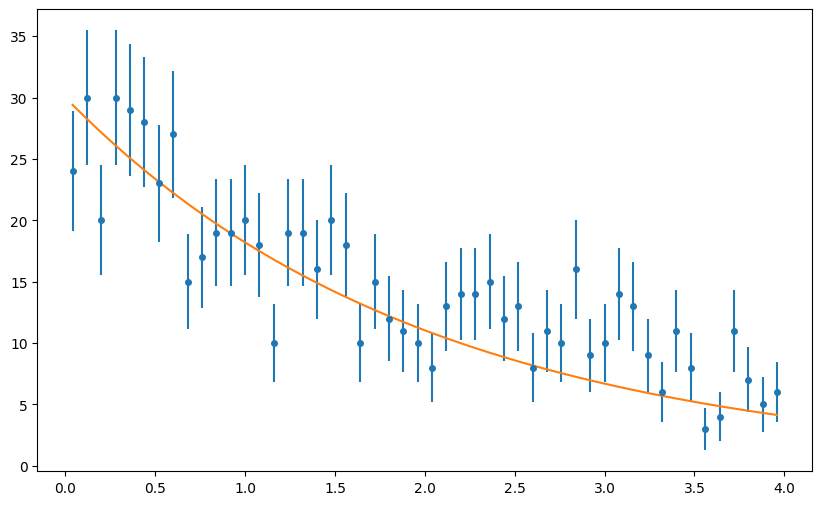

In [9]:
plt.figure(figsize=(10, 6))
plt.errorbar(bin_centers, counts, yerr=errs, fmt='o', label='Data', markersize=4)
plt.plot(bin_centers,expo(bin_centers,params['scale'].value,params['lambda_'].value))

The initial guess for the paraemter values looks pretty good.  Therfore the minimzer should be able to converge to a good minimum.

In [11]:
# Perform the fit
result = minimize(objective, params, args=(bin_centers, counts, errs), method='nelder')

In [12]:
result.chisqr

np.float64(6573830.81993018)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 80
    # data points      = 1
    # variables        = 2
    chi-square         = 6573830.82
    reduced chi-square = 6573830.82
    Akaike info crit   = 19.6986073
    Bayesian info crit = 15.6986073
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    scale:    27.1983689 (init = 30)
    lambda_:  2.83698551 (init = 2)


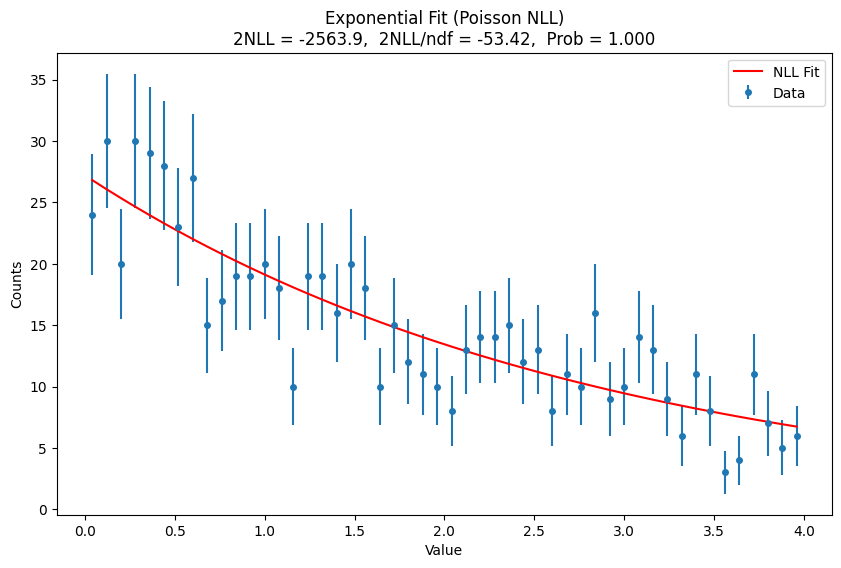

In [17]:
from scipy import stats

from lmfit import fit_report

print(fit_report(result, show_correl=True))

# Compute best-fit model
best_fit = expo(bin_centers,
                result.params['scale'].value,
                result.params['lambda_'].value)

mu = np.clip(best_fit, 1e-12, None)
data = counts
nll = np.sum(mu - data * np.log(mu))       # Poisson -logL (up to const)
twoNLL = 2 * nll                          
ndof = len(data) - len(result.params)

red_twoNLL = twoNLL / ndof
prob = 1 - stats.chi2.cdf(twoNLL, ndof)    # likelihood ratio prob

# --- Plot results ---
plt.figure(figsize=(10, 6))
plt.errorbar(bin_centers, counts, yerr=np.sqrt(counts),
             fmt='o', label='Data', markersize=4)
plt.plot(bin_centers, best_fit, 'r-', label='NLL Fit')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.legend()
plt.title('Exponential Fit (Poisson NLL)\n'
          f'2NLL = {twoNLL:.1f},  2NLL/ndf = {red_twoNLL:.2f},  Prob = {prob:.3f}')
plt.show()

# print("\nFit Results (Poisson NLL):")
# for name, param in result.params.items():
#     print(f"{name:8s} = {param.value:8.3f} ± {param.stderr:8.3f}")
# print(f"2*NLL = {twoNLL:.3f}")
# print(f"2*NLL/ndf = {red_twoNLL:.3f}")
# print(f"Prob(>2NLL) = {prob:.3f}")


In [18]:
# using the internal fit report
from lmfit import fit_report
print(fit_report(result))

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 80
    # data points      = 1
    # variables        = 2
    chi-square         = 6573830.82
    reduced chi-square = 6573830.82
    Akaike info crit   = 19.6986073
    Bayesian info crit = 15.6986073
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    scale:    27.1983689 (init = 30)
    lambda_:  2.83698551 (init = 2)
